-----------------------------Smart Predictive Modeling for Rental Property Prices----------------------------------------

In [668]:
#Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
import numpy as np

In [669]:
#Loading train_data
df=pd.read_excel("train_data.xlsx")
pd.set_option("display.max_columns",None)
df.head(3)

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent
0,ff8081815733a243015733b2876600a6,BHK2,NaN,21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",CORP_BORE,AP,2.0,40000.0
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2.0,22000.0
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3.0,28000.0


In [670]:
df.shape

(20555, 25)

In [671]:
#Checking for Duplicates and NaN Values
print("Duplicate rows :",df.duplicated().sum())
print("Nan Values:\n",df.isnull().sum())

Duplicate rows : 32
Nan Values:
 id                   0
type                27
locality           160
activation_date     23
latitude            23
longitude           23
lease_type          23
gym                  0
lift                 0
swimming_pool        0
negotiable           0
furnishing           0
parking              0
property_size        0
property_age        23
bathroom            23
facing              23
cup_board           23
floor               23
total_floor         23
amenities           23
water_supply        23
building_type       23
balconies           23
rent                23
dtype: int64


In [672]:
#Droping Duplicates and NaN Values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [673]:
#Checking for Unique 3
columns = ['type', 'locality', 'lease_type' ,'furnishing', 'parking', 'facing', 'water_supply', 'building_type']
for col in columns:
    print(col,":",df[col].unique())

type : ['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4PLUS' '1BHK1' 'bhk2' 'bhk3']
locality : ['Bellandur' 'Thiruvanmiyur' 'Attiguppe' ...
 'Reliance Fresh, Whitefield Main Road, Industrial Area, Whitefield'
 'Koramangala 4th block'
 'Mahadevapura bus stop, Mahadevapura, Bengaluru, Karnataka, India']
lease_type : ['ANYONE' 'FAMILY' 'BACHELOR' 'COMPANY']
furnishing : ['SEMI_FURNISHED' 'FULLY_FURNISHED' 'NOT_FURNISHED']
parking : ['BOTH' 'TWO_WHEELER' 'NONE' 'FOUR_WHEELER']
facing : ['NE' 'E' 'S' 'N' 'SE' 'W' 'NW' 'SW']
water_supply : ['CORPORATION' 'CORP_BORE' 'BOREWELL']
building_type : ['AP' 'IH' 'IF' 'GC']


In [674]:
#Replacing the Similar values by Single unique value
df['type'] = df['type'].replace({'bhk2': 'BHK2','bhk3': 'BHK3','1BHK1': 'BHK1'})
#Removing negative values in property age
df = df[df["property_age"] >=0]

In [675]:
df.dtypes

id                  object
type                object
locality            object
activation_date     object
latitude           float64
longitude          float64
lease_type          object
gym                  int64
lift                 int64
swimming_pool        int64
negotiable           int64
furnishing          object
parking             object
property_size        int64
property_age       float64
bathroom           float64
facing              object
cup_board          float64
floor              float64
total_floor        float64
amenities           object
water_supply        object
building_type       object
balconies          float64
rent               float64
dtype: object

In [676]:
#Converting into datetime format
df['activation_date']=pd.to_datetime(df['activation_date'])
df['year'] = df['activation_date'].dt.year

In [677]:
#Converting specific columns to "int64"
columns_int_datatype= ['property_age', 'bathroom', 'cup_board', 'floor', 'total_floor', 'balconies', 'rent']
for col in columns_int_datatype:
    df[col]=df[col].astype('Int64')

In [678]:
#Checking for Outliers
df.describe()

,activation_date,latitude,longitude,gym,lift,swimming_pool,negotiable,property_size,property_age,bathroom,cup_board,floor,total_floor,balconies,rent,year
count,20324,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.0,20324.0,20324.0,20324.0,20324.0,20324.0,20324.0,20324.000000
mean,2018-02-13 12:35:30.625861120,12.945742,77.637262,0.226530,0.360903,0.174720,0.711179,1061.896920,5.787247,1.858296,4.574788,1.869907,3.798071,1.147609,19049.121482,2017.636883
min,2017-01-07 10:25:00,12.900004,77.500072,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,8000.0,2017.000000
25%,2017-10-21 11:37:15,12.918244,77.571908,0.000000,0.000000,0.000000,0.000000,700.000000,1.0,1.0,1.0,1.0,2.0,0.0,12500.0,2017.000000
50%,2018-03-03 15:01:30,12.943787,77.633368,0.000000,0.000000,0.000000,1.000000,1047.000000,5.0,2.0,2.0,1.0,3.0,1.0,17500.0,2018.000000
75%,2018-06-16 13:53:30,12.970897,77.695710,0.000000,1.000000,0.000000,1.000000,1280.250000,10.0,2.0,3.0,2.0,4.0,2.0,24000.0,2018.000000
max,2018-12-07 23:17:00,12.999999,80.266346,1.000000,1.000000,1.000000,1.000000,50000.000000,400.0,21.0,48026.0,25.0,26.0,13.0,50000.0,2018.000000
std,NaN,0.029577,0.110853,0.418596,0.480274,0.379736,0.453226,592.116762,6.359578,0.711076,336.865414,2.183124,3.185944,0.993537,8431.391358,0.480910


In [679]:
import json
#Converting "str" to "dict"
def str_to_dict(x,col):
    dictionary=json.loads(x)
    if  col in dictionary:
        return dictionary["LIFT" ]
    else:
        return False
columns=['LIFT', 'GYM', 'INTERNET', 'AC', 'CLUB', 'POOL', 'SERVANT', 'SECURITY', 'PARK']
#Creating seperate columns for Different Amenities
for col in columns:
   df[col] = df['amenities'].apply(lambda x : str_to_dict(x,col))


In [680]:
df.head(3)

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent,year,LIFT,GYM,INTERNET,AC,CLUB,POOL,SERVANT,SECURITY,PARK
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4,2,NE,2,3,4,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2,22000,2017,True,True,True,True,True,True,True,True,True
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6,3,E,3,1,5,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3,28000,2018,True,True,True,True,True,True,True,True,True
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,2018-07-20 16:22:00,12.955991,77.531634,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3,1,E,1,1,2,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,0,8000,2018,False,False,False,False,False,False,False,False,False


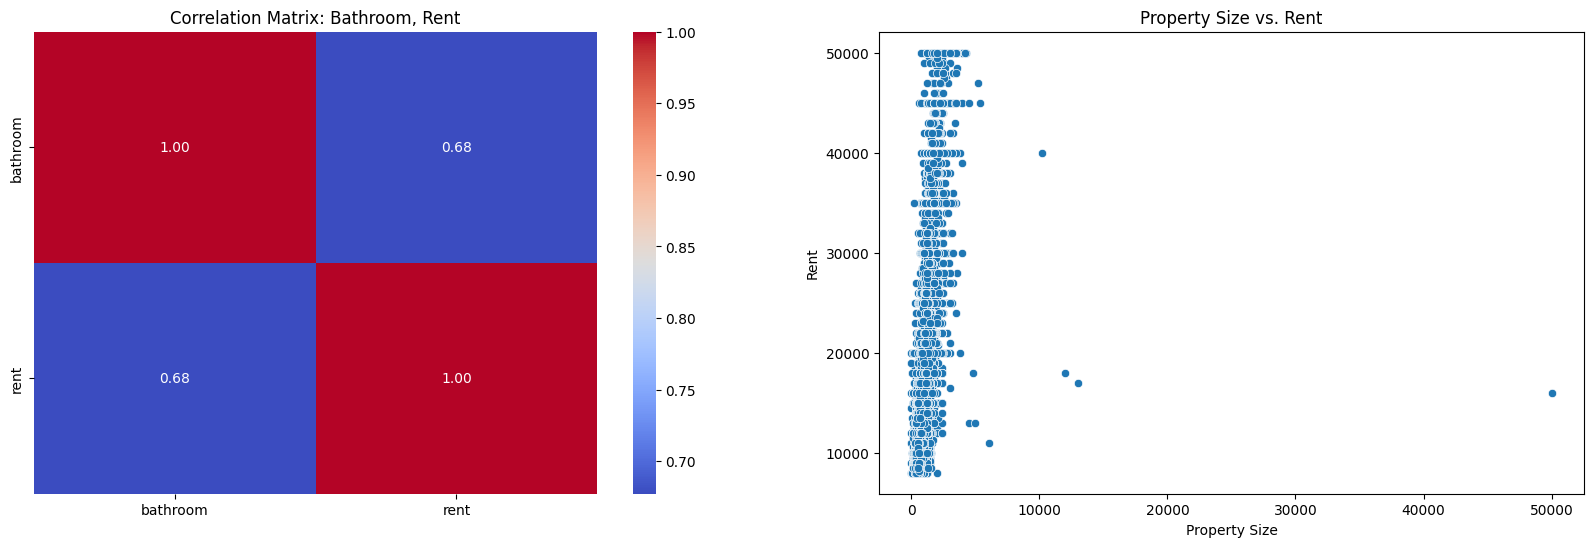

In [681]:
#Correlation Analysis

#---------------------------------------------------------------------------------------------------------------------
#Bathroom vs Rent

data_1= df[['bathroom','rent']]
correlation_matrix = data_1.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Bathroom, Rent')
#---------------------------------------------------------------------------------------------------------------------
#Property size vs Rent

data_2 = df[['property_size', 'rent']]
correlation_matrix_size = data_2.corr()
# Visualize the correlation using a scatter plot
plt.subplot(1,2,2)
sns.scatterplot(x='property_size', y='rent', data=data_2)
plt.title('Property Size vs. Rent')
plt.xlabel('Property Size')
plt.ylabel('Rent')
plt.show()


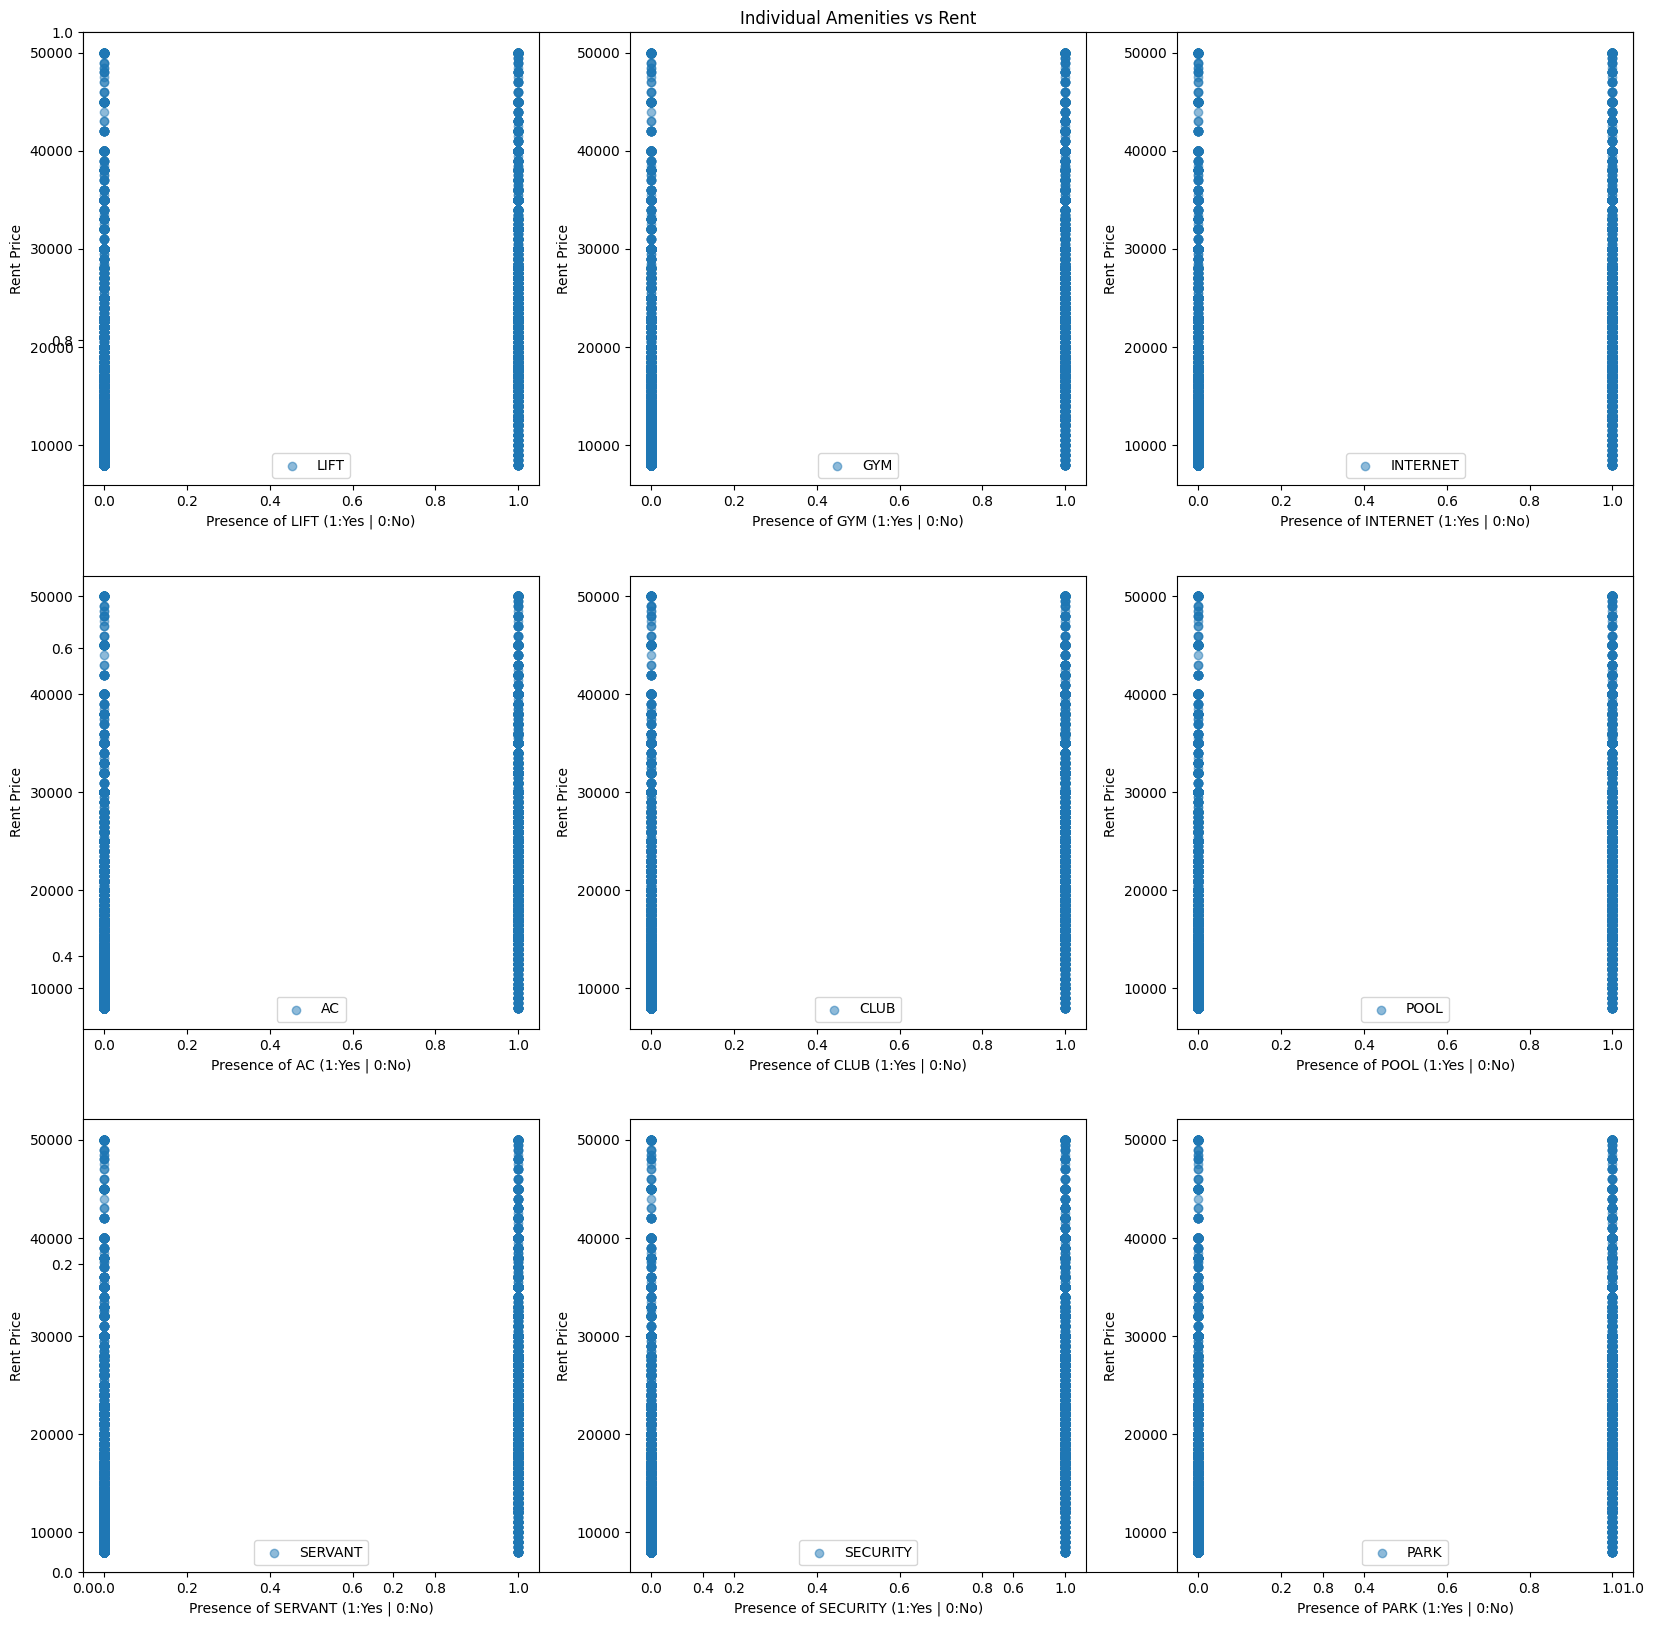

In [682]:
#Amenities vs Rent
columns=['LIFT', 'GYM', 'INTERNET', 'AC', 'CLUB', 'POOL', 'SERVANT', 'SECURITY', 'PARK']
j=1
plt.figure(figsize=(20,20))
plt.title("Individual Amenities vs Rent")
for amenity in columns:
  
    plt.subplot(3,3,j)
    j=j+1 
    plt.scatter(df[amenity], df["rent"], label=amenity, alpha=0.5)
    plt.xlabel(f"Presence of {amenity} (1:Yes | 0:No)")
    plt.ylabel("Rent Price")
    plt.legend()
   
plt.show() 

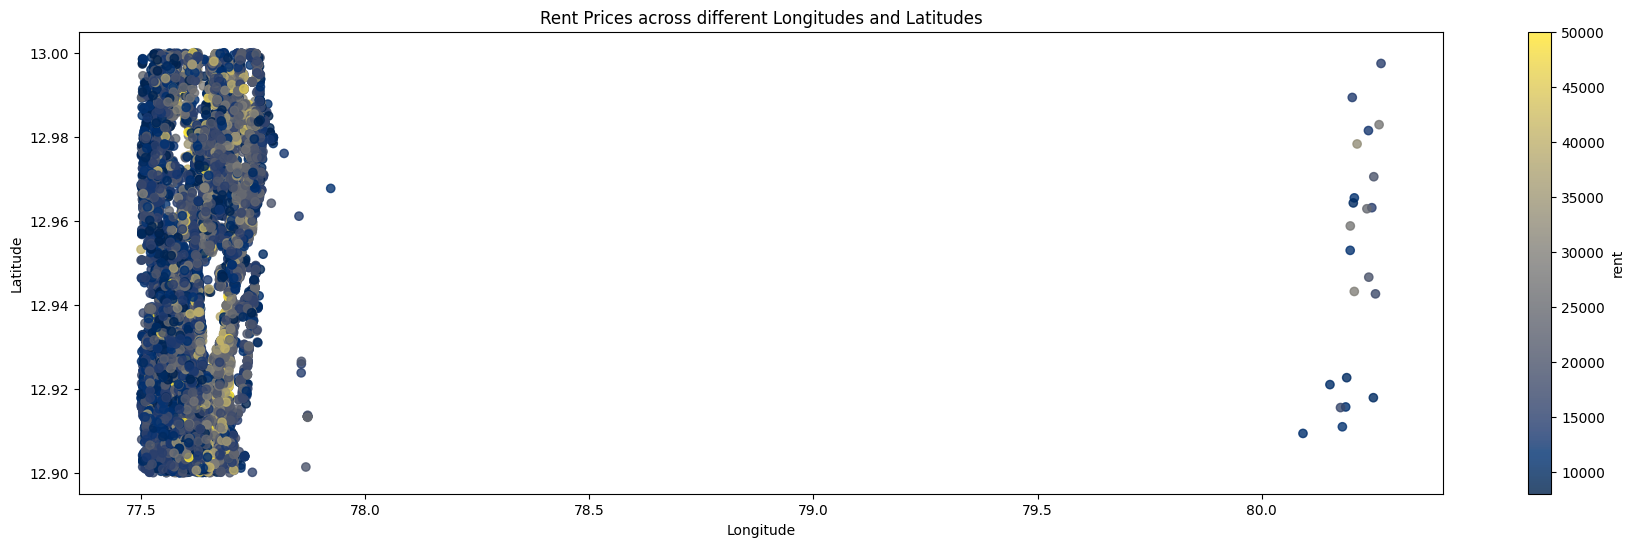

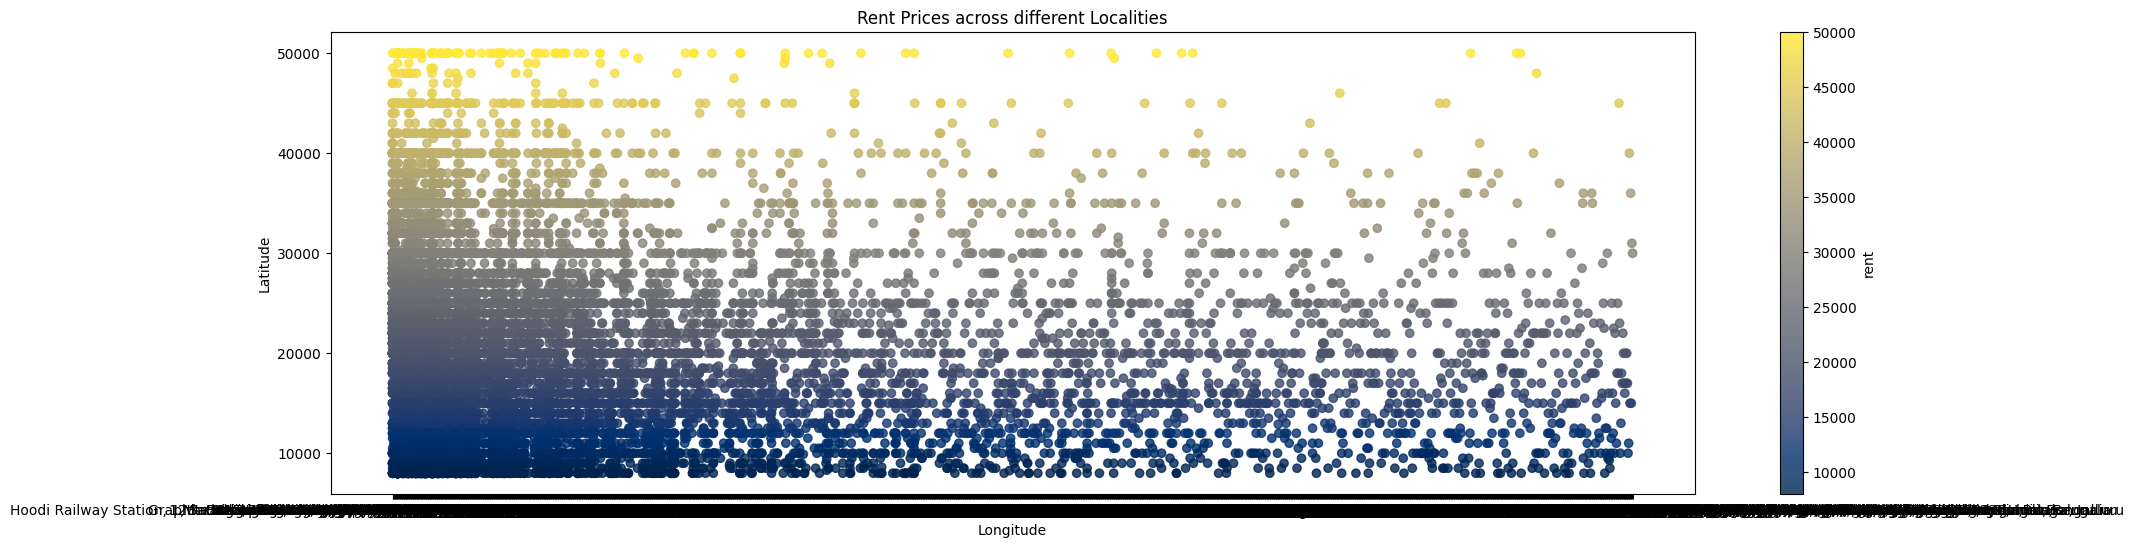

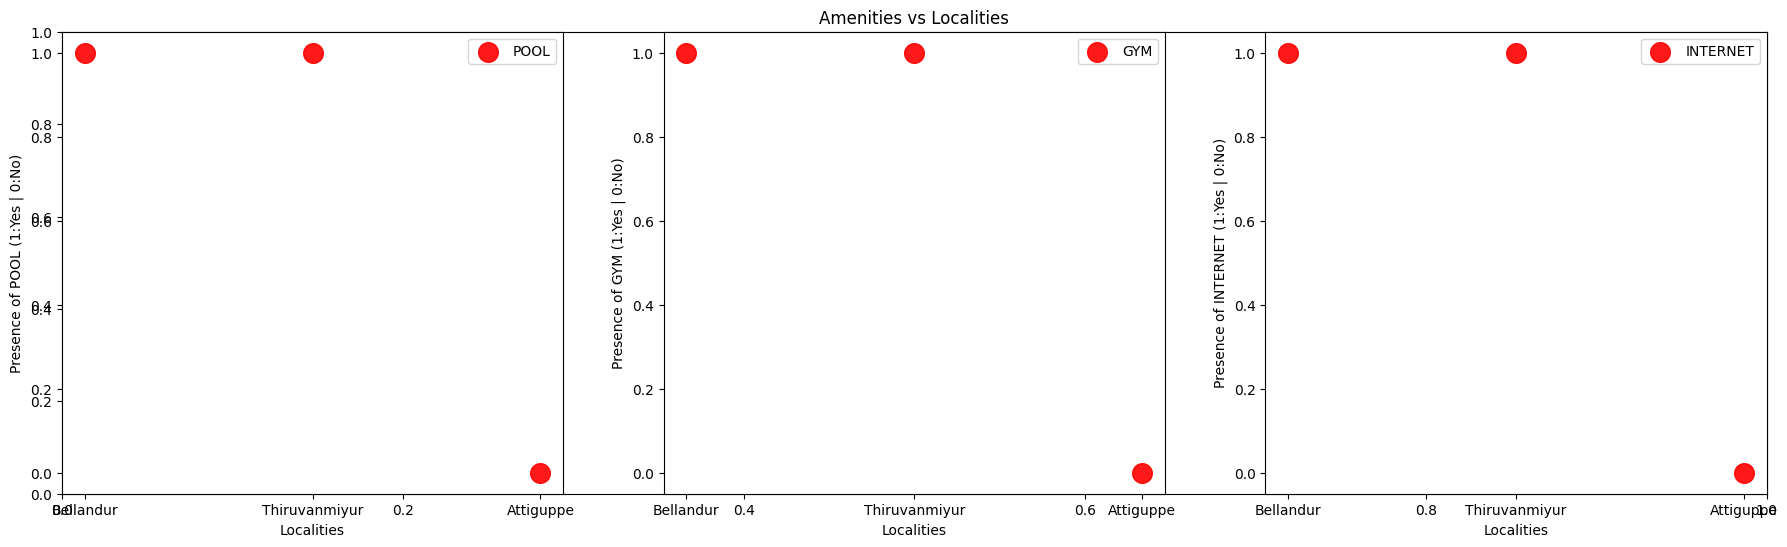

In [683]:
#Price across different Longitudes and Latitudes

plt.figure(figsize=(22, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['rent'], cmap='cividis', alpha=0.8)
plt.colorbar(label='rent')
plt.title('Rent Prices across different Longitudes and Latitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
#---------------------------------------------------------------------------------------------------------------------
#Rent Prices across different Localities

plt.figure(figsize=(22, 6))
plt.scatter(df["locality"], df['rent'], c=df['rent'],cmap='cividis', alpha=0.8)
plt.colorbar(label='rent')
plt.title('Rent Prices across different Localities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
#---------------------------------------------------------------------------------------------------------------------

j=1
plt.figure(figsize=(22,6))
plt.title("Amenities vs Localities")
amenities = ['POOL', 'GYM', 'INTERNET']
for amenity in amenities:
    plt.subplot(1,3,j)
    j=j+1 
    plt.scatter(df["locality"].iloc[:3], df[amenity].iloc[:3], c="red",label=amenity, alpha=0.9,s=200) #Choosen only 3 localities for better visualization
    plt.xlabel("Localities")
    plt.ylabel(f"Presence of {amenity} (1:Yes | 0:No)")
    plt.legend()

In [684]:
#Handling Outliers Using Logarithmic Function
for col in["property_age","property_size",'cup_board','floor','total_floor','balconies','bathroom']:
            df[col] = np.log1p(df[col])

In [685]:
df.describe()

,activation_date,latitude,longitude,gym,lift,swimming_pool,negotiable,property_size,property_age,bathroom,cup_board,floor,total_floor,balconies,rent,year
count,20324,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.000000,20324.0,20324.0,20324.0,20324.0,20324.0,20324.0,20324.0,20324.000000
mean,2018-02-13 12:35:30.625861120,12.945742,77.637262,0.226530,0.360903,0.174720,0.711179,6.864006,1.546291,1.020503,1.062666,0.849436,1.421064,0.655069,19049.121482,2017.636883
min,2017-01-07 10:25:00,12.900004,77.500072,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,8000.0,2017.000000
25%,2017-10-21 11:37:15,12.918244,77.571908,0.000000,0.000000,0.000000,0.000000,6.552508,0.693147,0.693147,0.693147,0.693147,1.098612,0.0,12500.0,2017.000000
50%,2018-03-03 15:01:30,12.943787,77.633368,0.000000,0.000000,0.000000,1.000000,6.954639,1.791759,1.098612,1.098612,0.693147,1.386294,0.693147,17500.0,2018.000000
75%,2018-06-16 13:53:30,12.970897,77.695710,0.000000,1.000000,0.000000,1.000000,7.155591,2.397895,1.098612,1.386294,1.098612,1.609438,1.098612,24000.0,2018.000000
max,2018-12-07 23:17:00,12.999999,80.266346,1.000000,1.000000,1.000000,1.000000,10.819798,5.993961,3.091042,10.779519,3.258097,3.295837,2.639057,50000.0,2018.000000
std,NaN,0.029577,0.110853,0.418596,0.480274,0.379736,0.453226,0.479905,0.918363,0.243881,0.474443,0.620977,0.514183,0.476362,8431.391358,0.480910


Machine Learning REGRESSION Model

In [686]:
#Making  a copy of DataFrame
df_new=df.copy()

In [687]:
#Dropping Unnecessary Columns 
df_new.drop(["id","amenities","activation_date"],axis="columns",inplace=True)

In [688]:
#Label Encoding
columns = ['locality','type', 'lease_type', 'furnishing','parking', 'facing', 'water_supply', 'building_type']
for cols in columns:
    label_encoder = LabelEncoder()
    df_new[cols] = label_encoder.fit_transform(df_new[cols])

In [689]:
#Datasets after Encoding
df_new.head(10)

,type,locality,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,year,LIFT,GYM,INTERNET,AC,CLUB,POOL,SERVANT,SECURITY,PARK
1,1,375,12.929557,77.672280,0,0,1,0,1,2,0,7.244942,1.609438,1.098612,2,1.098612,1.386294,1.609438,1,0,1.098612,22000,2017,True,True,True,True,True,True,True,True,True
2,2,1685,12.982870,80.262012,3,0,1,0,0,2,0,7.208600,1.94591,1.386294,0,1.386294,0.693147,1.791759,2,0,1.386294,28000,2018,True,True,True,True,True,True,True,True,True
3,0,227,12.955991,77.531634,3,0,0,0,1,2,3,6.398595,1.386294,0.693147,0,0.693147,0.693147,1.098612,1,3,0.0,8000,2018,False,False,False,False,False,False,False,False,False
4,2,1057,12.963903,77.649446,3,0,0,0,1,2,0,7.313887,2.772589,1.386294,0,1.609438,0.0,0.0,1,3,0.693147,45000,2018,False,False,False,False,False,False,False,False,False
5,0,1552,12.986196,77.718314,3,1,1,1,1,2,0,6.985642,0.0,1.098612,0,0.693147,1.386294,1.791759,2,0,1.098612,18000,2017,True,True,True,True,True,True,True,True,True
6,2,1322,12.967144,77.750662,0,1,1,1,1,0,0,7.547502,1.791759,1.386294,2,1.791759,1.386294,2.302585,1,0,1.386294,32000,2018,True,True,True,True,True,True,True,True,True
7,1,696,12.917414,77.631764,0,0,0,0,1,2,0,6.908755,2.397895,1.098612,4,1.098612,0.0,1.098612,2,3,0.0,22000,2018,False,False,False,False,False,False,False,False,False
8,1,306,12.923301,77.556324,0,0,0,0,0,2,2,6.803505,2.397895,1.098612,4,1.098612,0.0,0.693147,1,3,0.0,10000,2018,False,False,False,False,False,False,False,False,False
9,1,1830,12.972697,77.751880,0,1,1,0,1,2,0,7.163172,1.609438,1.098612,0,1.609438,1.098612,1.609438,2,0,1.098612,19500,2018,True,True,True,True,True,True,True,True,True
10,1,1430,12.912039,77.510950,3,0,0,0,1,2,0,7.090910,1.098612,1.098612,0,1.609438,0.693147,1.098612,1,2,0.693147,12500,2017,False,False,False,False,False,False,False,False,False


In [690]:
#Splitting Features(X) and labels(y)

X=df_new.iloc[:,:]
X.drop("rent",axis=1,inplace=True)
y=df_new["rent"]

In [691]:

# #Splitting data for training and Testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 42)
#Model Execution
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
mse_rf = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print('R2 SCORE:',r2_score(y_test,y_pred))


Mean Squared Error (Random Forest): 14230782.195713775
R2 SCORE: 0.8083648587599723


In [692]:
#Dataframe Containing Actual and Predicted Rental Price
df_ap=pd.DataFrame({"Actual_Rent(₹)":y_test,"Predicted_Rent(₹)":y_pred})
df_ap["Predicted_Rent(₹)"]=df_ap["Predicted_Rent(₹)"].apply(lambda x:round(x))
pd.set_option("display.max_rows",None)
df_ap.head(10)

,Actual_Rent(₹),Predicted_Rent(₹)
8133,16000,15669
11040,20000,18385
3055,18000,20882
8192,21000,22164
1108,30000,33025
15664,19000,17618
3288,25800,24480
211,10000,10850
6280,16000,12400
15630,24500,20240


In [693]:
#Saving the trained model
import pickle
with open ("rfg.pkl","wb") as file:
    pickle.dump(model,file)

------------------------------------------------Predicting sample data--------------------------------------------------

In [694]:
#Loading sample data
df_input=pd.read_excel("sample.xlsx")
df_input.head(3)


,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies
0,ff8081815df539bc015df947ce976cca,BHK2,Basavanagudi,22-08-2017 09:00,12.941603,77.568156,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1300,1,2,N,2,3,3,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,1
1,ff80818157288e9301572c05651853a6,BHK2,Rajaji Nagar,17-09-2017 16:33,12.998803,77.561887,ANYONE,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,7,1,S,2,0,3,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IF,0
2,ff8081815f1afc58015f1b831fde166e,BHK1,Jeevan Bima Nagar,14-04-2018 17:27,12.966467,77.661063,ANYONE,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,10,1,S,1,0,1,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IF,0


In [695]:
df_sample=df_input.copy()
df_input.shape

(4500, 24)

In [696]:

print(df_sample.shape)
print( df_sample.duplicated().sum())
print(df_sample.isnull().sum())

(4500, 24)
0
id                 0
type               0
locality           0
activation_date    0
latitude           0
longitude          0
lease_type         0
gym                0
lift               0
swimming_pool      0
negotiable         0
furnishing         0
parking            0
property_size      0
property_age       0
bathroom           0
facing             0
cup_board          0
floor              0
total_floor        0
amenities          0
water_supply       0
building_type      0
balconies          0
dtype: int64


In [697]:
df_sample.drop_duplicates(inplace=True)
df_sample.dropna(inplace=True)

In [698]:
# Mapping similar values to unique values in selected columns
columns = ['type', 'locality', 'lease_type', 'furnishing', 'parking', 'facing', 'water_supply', 'building_type']
for col in columns:
    print(col, ":", df_sample[col].unique())

type : ['BHK2' 'BHK1' 'BHK3' 'RK1' 'BHK4' 'BHK4PLUS']
locality : ['Basavanagudi' 'Rajaji Nagar' 'Jeevan Bima Nagar' 'Jayanagar 1st Block'
 'Whitefield Hope Farm Junction' 'Kumaraswamy Layout' 'Bellandur'
 '3, Kathriguppa Main Rd, ITI Layout, Banashankari 3rd Stage, Banashankari'
 'New Thippasandra' 'Wilson Garden' 'Chikkalasandra'
 'Whitefield, Bengaluru, Karnataka, India' 'Vibhutipura' 'Kasavanahalli'
 'HSR Layout' 'Kaggadasapura' 'JP Nagar' 'Kathriguppe' 'Whitefield'
 'BTM 2nd Stage' 'HSR layout Sector 2' 'Munnekolal' 'Jakkasandra' 'Ulsoor'
 'Battarahalli' 'Kasavanhalli' 'RR Nagar' 'Shanti Nagar'
 'Thubarahalli,Whitefield' 'Narayanappa Garden,Whitefield'
 'jagadish nagar , Kaggadasapura' 'Jayanagar' 'Koramangala' 'J P Nagar'
 'LB Shastri Nagar' 'Vijayanagar' 'Murgesh Pallya' 'Jayanagar 3rd Block'
 'Doddakannelli' 'Marathahalli' 'Tavarekere' 'Uttarahalli Hobli' 'Domlur'
 'Mavalli' 'Banashankari' 'Ambedkar Nagar,Whitefield' 'New Tippasandra'
 '2nd Phase, JP Nagar' 'Kamaksipalya' 'EPIP 

In [699]:
# Replacing similar values with a single unique value in 'type' column
df_sample['type'] = df_sample['type'].replace({'bhk2': 'BHK2', 'bhk3': 'BHK3', '1BHK1': 'BHK1'})

In [700]:
#Converting into 'int64' datatype
columns_int_datatype = ['property_age', 'bathroom', 'cup_board', 'floor', 'total_floor', 'balconies']
for col in columns_int_datatype:
    df_sample[col] = df_sample[col].astype('Int64')

In [701]:
# Converting 'activation_date' to datetime
df_sample['activation_date'] = pd.to_datetime(df_sample['activation_date'])
# Creating a new column 'year' based on 'activation_date'
df_sample['year'] = df_sample['activation_date'].dt.year

C:\Users\banup\AppData\Local\Temp\ipykernel_23312\252572043.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sample['activation_date'] = pd.to_datetime(df_sample['activation_date'])


In [702]:
# Dropping rows with negative data in 'property_age'
df_sample = df_sample[df_sample["property_age"] >= 0]


In [703]:
for col in ["property_age", "property_size", 'cup_board', 'floor', 'total_floor', 'balconies', 'bathroom']:
    df_sample[col] = np.log1p(df_sample[col])

In [704]:
import json
#Converting "str" to "dict"
def str_to_dict(x,col):
    dictionary=json.loads(x)
    if  col in dictionary:
        return dictionary["LIFT" ]
    else:
        return False
columns=['LIFT', 'GYM', 'INTERNET', 'AC', 'CLUB', 'POOL', 'SERVANT', 'SECURITY', 'PARK']
#Creating seperate columns for Different Amenities
for col in columns:
   df_sample[col] = df_sample['amenities'].apply(lambda x : str_to_dict(x,col))

In [705]:
# Dropping unnecessary columns
df_sample.drop(["id", "amenities", "activation_date"], axis="columns", inplace=True)

In [706]:
# Label encoding for selected columns
label_columns = ['locality', 'type', 'lease_type', 'furnishing', 'parking', 'facing', 'water_supply', 'building_type']
label_encoder = LabelEncoder()
for col in label_columns:
    df_sample[col] = label_encoder.fit_transform(df_sample[col])

In [707]:
#Machine Learning Model
#Features(X_sample_test)
X_sample_test=df_sample.iloc[:,:]
#Predicting the rent
rent_prediction=model.predict(X_sample_test)

In [708]:
#Input Features and Predicted Rent
df_pred=pd.DataFrame({"Predicted_Rent(₹)":rent_prediction})
df_pred.head()


,Predicted_Rent(₹)
0,26825.0
1,11692.5
2,11572.5
3,9775.5
4,24587.5


In [709]:
#Input Features and Predicted Rent
df_result=pd.concat([df_input,df_pred],axis=1)
df_result.head(3)

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,Predicted_Rent(₹)
0,ff8081815df539bc015df947ce976cca,BHK2,Basavanagudi,22-08-2017 09:00,12.941603,77.568156,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1300,1,2,N,2,3,3,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,1,26825.0
1,ff80818157288e9301572c05651853a6,BHK2,Rajaji Nagar,17-09-2017 16:33,12.998803,77.561887,ANYONE,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,7,1,S,2,0,3,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IF,0,11692.5
2,ff8081815f1afc58015f1b831fde166e,BHK1,Jeevan Bima Nagar,14-04-2018 17:27,12.966467,77.661063,ANYONE,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,10,1,S,1,0,1,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IF,0,11572.5
